# Rossman Sales Prediction - Part 2

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import datetime
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Settings and Auxiliary Functions

In [2]:
plt.rcParams["figure.figsize"] = [9,6]
sns.set_theme()

In [3]:
def calc_error( model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    return pd.DataFrame({"Model": model_name, "MAE": mae, "MAPE": mape, "RMSE": rmse}, index=[0])

In [4]:
def plot_scatter(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(6,5))
    min_x, max_x = y_test.min(), y_test.max()
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([min_x, max_x],[min_x, max_x])
    ax.set_xlabel("Actual Sales")
    ax.set_ylabel("Predicted Sales")
    return None  

In [5]:
def cross_validate(data, n_splits, model_name, model):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, n_splits+1)):
        # Validation interval of 6 weeks
        val_start_date = data["Date"].max() - datetime.timedelta(days=k*6*7)
        val_end_date = data["Date"].max() - datetime.timedelta(days=(k-1)*6*7)
        
        training = data[data["Date"] < val_start_date]
        validation = data[(data["Date"] >= val_start_date) & (data["Date"] <= val_end_date)]
        
        X_train = training.drop(columns=["Date", "Sales"])
        y_train = training["Sales"]
        
        X_valid = validation.drop(columns=["Date", "Sales"])
        y_valid = validation["Sales"]
        
        m = model.fit(X_train, y_train)
        y_pred = m.predict(X_valid)
        
        error = calc_error(model_name, np.exp(y_valid), np.exp(y_pred))
        
        mae_list.append(error["MAE"])
        mape_list.append(error["MAPE"])
        rmse_list.append(error["RMSE"])
        
    return pd.DataFrame( {"Model name":model_name, "MAE": np.round(np.mean(mae_list), 2).astype(str) + " +/- " + np.round(np.std(mae_list), 2).astype(str),
                          "MAPE": np.round(np.mean(mape_list), 2).astype(str) + " +/- " + np.round(np.std(mape_list), 2).astype(str),
                          "RMSE": np.round(np.mean(rmse_list), 2).astype(str) + " +/- " + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

# Data Loading

In [20]:
data = pd.read_csv("filtered_data.csv", low_memory=False, index_col=0)

In [21]:
data.head()

,Store,DayOfWeek,Date,Sales,Promo,StoreType,Assortment,Promo2
0,1,5,2015-07-31,5263,1,c,basic,0
1,2,5,2015-07-31,6064,1,a,basic,1
2,3,5,2015-07-31,8314,1,a,basic,1
3,4,5,2015-07-31,13995,1,c,extended,0
4,5,5,2015-07-31,4822,1,a,basic,0


In [22]:
data["Date"] = data["Date"].astype("datetime64")

# Data Preparation

## Encoding

In [23]:
le = LabelEncoder()
data["StoreType"] = le.fit_transform(data["StoreType"])
pickle.dump(le, open('data/storetype_encoder.pkl', 'wb'))

data["Assortment"] = data["Assortment"].map({"basic":1, "extra":2, "extended":3})

## Cyclical Variables

In [24]:
data["Day"] = data["Date"].dt.day
data["Month"] = data["Date"].dt.month
data["Year"] = data["Date"].dt.year
data["Week"] = data["Date"].dt.isocalendar().week

In [25]:
data["Day_sin"] = data["Day"].apply(lambda x: np.sin(x * np.pi/31))
data["Day_cos"] = data["Day"].apply(lambda x: np.cos(x * np.pi/31))

data["DayOfWeek_sin"] = data["DayOfWeek"].apply(lambda x: np.sin(x * np.pi/7))
data["DayOfWeek_cos"] = data["DayOfWeek"].apply(lambda x: np.cos(x * np.pi/7))

data["Week_sin"] = data["Week"].apply(lambda x: np.sin(x * np.pi/52))
data["Week_cos"] = data["Week"].apply(lambda x: np.cos(x * np.pi/52))

data["Month_sin"] = data["Month"].apply(lambda x: np.sin(x * np.pi/12))
data["Month_cos"] = data["Month"].apply(lambda x: np.cos(x * np.pi/12))

In [26]:
data = data.drop(columns=["DayOfWeek", "Day", "Month", "Week"])

## Target Variable Transformation

In [27]:
data["Sales"] = np.log(data["Sales"])

# Feature Selection

## Test-train Split

In [28]:
aux = data.copy()

In [29]:
time_cutoff = aux["Date"].max() - datetime.timedelta(days=42)

train_df = aux[aux["Date"] < time_cutoff]

test_df = aux[aux["Date"] >= time_cutoff]

In [30]:
X_train = train_df.copy().drop(columns=["Sales", "Date"])
y_train = train_df["Sales"].copy()

X_test = test_df.copy().drop(columns=["Sales", "Date"])
y_test = test_df["Sales"].copy()

# Model Training

## Baseline (Average) Model

In [31]:
aux1 = X_train.copy()
aux1["Sales"] = y_train.copy()
aux1 = aux1[["Store", "Sales"]].groupby("Store").mean().reset_index()

aux2 = X_test.copy()
bl_pred = pd.merge(aux1, aux2, how="right", on="Store")["Sales"]

baseline_error = calc_error("Baseline", np.exp(y_test).values, np.exp(bl_pred))
baseline_error

,Model,MAE,MAPE,RMSE
0,Baseline,1429.764812,0.216813,1939.336071


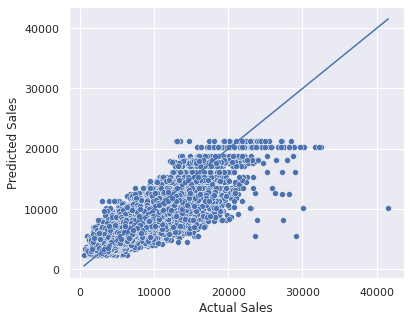

In [32]:
plot_scatter(np.exp(y_test).values, np.exp(bl_pred))

## Linear Regression

In [33]:
lr = LinearRegression().fit(X_train, y_train)
l_pred = lr.predict(X_test)
linear_error = calc_error("Linear Regression", np.exp(y_test), np.exp(l_pred))
linear_error

,Model,MAE,MAPE,RMSE
0,Linear Regression,1872.234082,0.295008,2676.976699


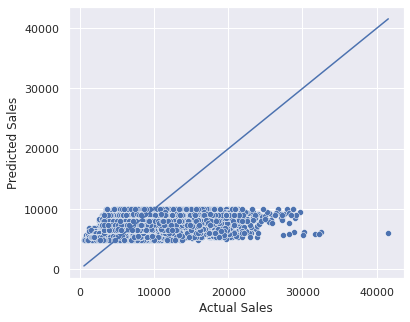

In [34]:
plot_scatter(np.exp(y_test), np.exp(l_pred))

## Random Forest Regression

In [35]:
rf = RandomForestRegressor(n_estimators=10, random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_error = calc_error("Random Forest", np.exp(y_test), np.exp(rf_pred))

In [36]:
rf_error

,Model,MAE,MAPE,RMSE
0,Random Forest,765.087107,0.113195,1158.529725


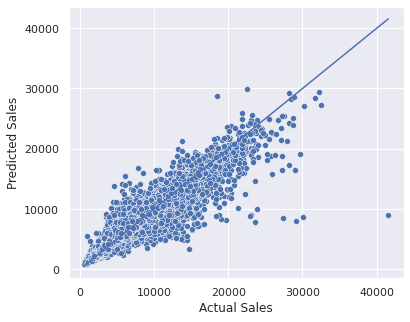

In [37]:
plot_scatter(np.exp(y_test), np.exp(rf_pred))

In [ ]:
error_table = pd.concat([baseline_error, linear_error, rf_error])
error_table.sort_values("RMSE")

,Model,MAE,MAPE,RMSE
0,Random Forest,765.087107,0.113195,1158.529725
0,Baseline,1429.764812,0.216813,1939.336071
0,Linear Regression,1872.234082,0.295008,2676.976699


The Random Forest regression is the best so far, and a considerable improvement over the baseline, and it's the model we'll be using for now.

For ease of porting it to an app, we will also train a smaller model:

In [65]:
rf_small = RandomForestRegressor(n_estimators=5, max_depth=30)

In [66]:
rf_small.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=5)

In [67]:
rf_pred2 = rf_small.predict(X_test)
rf_error2 = calc_error("Random Forest", np.exp(y_test), np.exp(rf_pred2))

In [68]:
rf_error2

,Model,MAE,MAPE,RMSE
0,Random Forest,799.858182,0.116891,1236.016585


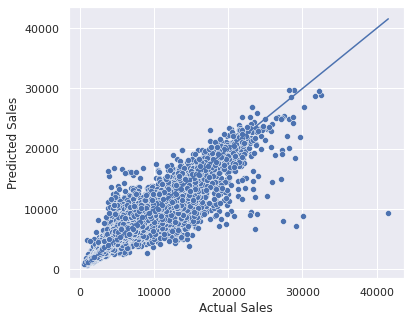

In [69]:
plot_scatter(np.exp(y_test), np.exp(rf_pred2))

In [71]:
pickle.dump(rf_small, open("data/rf_model.pkl", "wb"))

# Cross-validation

In [25]:
lr2 = LinearRegression()
cross_validate(data, n_splits=5, model_name="Linear Regression", model=lr2)

,Model name,MAE,MAPE,RMSE
0,Linear Regression,1933.5 +/- 114.94,0.29 +/- 0.01,2762.64 +/- 204.44


In [26]:
rf2 = RandomForestRegressor(n_estimators=10, random_state=0)
cross_validate(data, n_splits=5, model_name="Random Forest", model=rf2)

,Model name,MAE,MAPE,RMSE
0,Random Forest,782.65 +/- 102.58,0.11 +/- 0.01,1162.14 +/- 147.13


# Returning the Data to Kaggle

## Test Data Loading

In [27]:
df_test_raw = pd.read_csv("test.csv", low_memory=False)
df_store_raw = pd.read_csv("store.csv", low_memory=False)

In [29]:
df_test = pd.merge(df_test_raw, df_store_raw, on="Store", how="left")

## Test Data Transformation

In [41]:
features = ['Store', 'DayOfWeek', 'Date', 'Promo', 'StoreType', 'Assortment', 'Promo2']
df_test2 = df_test[features].copy()

In [46]:
df_test2["Date"] = df_test2["Date"].astype("datetime64")

In [43]:
df_test2["StoreType"] = le.transform(df_test2["StoreType"])

df_test2["Assortment"] = df_test2["Assortment"].map({"a":1, "b":2, "c":3})

In [47]:
df_test2["Day"] = df_test2["Date"].dt.day
df_test2["Month"] = df_test2["Date"].dt.month
df_test2["Year"] = df_test2["Date"].dt.year
df_test2["Week"] = df_test2["Date"].dt.isocalendar().week

In [48]:
df_test2["Day_sin"] = df_test2["Day"].apply(lambda x: np.sin(x * np.pi/31))
df_test2["Day_cos"] = df_test2["Day"].apply(lambda x: np.cos(x * np.pi/31))

df_test2["DayOfWeek_sin"] = df_test2["DayOfWeek"].apply(lambda x: np.sin(x * np.pi/7))
df_test2["DayOfWeek_cos"] = df_test2["DayOfWeek"].apply(lambda x: np.cos(x * np.pi/7))

df_test2["Week_sin"] = df_test2["Week"].apply(lambda x: np.sin(x * np.pi/52))
df_test2["Week_cos"] = df_test2["Week"].apply(lambda x: np.cos(x * np.pi/52))

df_test2["Month_sin"] = df_test2["Month"].apply(lambda x: np.sin(x * np.pi/12))
df_test2["Month_cos"] = df_test2["Month"].apply(lambda x: np.cos(x * np.pi/12))

In [49]:
df_test2 = df_test2.drop(columns=["DayOfWeek", "Day", "Month", "Week"])

In [54]:
df_test_final = df_test2.drop(columns=["Date"])

In [57]:
df_test_final

,Store,Promo,StoreType,Assortment,Promo2,Year,Day_sin,Day_cos,DayOfWeek_sin,DayOfWeek_cos,Week_sin,Week_cos,Month_sin,Month_cos
0,1,1,2,1,0,2015,0.988468,-0.151428,0.974928,-0.222521,0.748511,-0.663123,0.707107,-0.707107
1,3,1,0,1,1,2015,0.988468,-0.151428,0.974928,-0.222521,0.748511,-0.663123,0.707107,-0.707107
2,7,1,0,3,0,2015,0.988468,-0.151428,0.974928,-0.222521,0.748511,-0.663123,0.707107,-0.707107
3,8,1,0,1,0,2015,0.988468,-0.151428,0.974928,-0.222521,0.748511,-0.663123,0.707107,-0.707107
4,9,1,0,3,0,2015,0.988468,-0.151428,0.974928,-0.222521,0.748511,-0.663123,0.707107,-0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,0,0,1,1,2015,0.101168,0.994869,0.433884,-0.900969,0.954721,-0.297503,0.866025,-0.500000
41084,1112,0,2,3,0,2015,0.101168,0.994869,0.433884,-0.900969,0.954721,-0.297503,0.866025,-0.500000
41085,1113,0,0,3,0,2015,0.101168,0.994869,0.433884,-0.900969,0.954721,-0.297503,0.866025,-0.500000
41086,1114,0,0,3,0,2015,0.101168,0.994869,0.433884,-0.900969,0.954721,-0.297503,0.866025,-0.500000


In [59]:
final_predict = rf.predict(df_test_final)

In [61]:
final_predict_scaled = np.exp(final_predict)

In [62]:
final_predict_scaled

array([ 4152.74432146,  8185.89981943,  8747.53408728, ...,
        7277.25187813, 27799.05267874,  8917.01266758])

In [67]:
results = pd.DataFrame(final_predict_scaled, columns=["Sales"]).reset_index()

In [69]:
results.columns = ["Id", "Sales"]

In [70]:
results["Id"] = results["Id"] + 1

In [71]:
results

,Id,Sales
0,1,4152.744321
1,2,8185.899819
2,3,8747.534087
3,4,7247.885453
4,5,7931.977075
...,...,...
41083,41084,3698.603491
41084,41085,9227.535139
41085,41086,7277.251878
41086,41087,27799.052679


In [73]:
results.to_csv("results.csv", index=False)

In [1]:
import pickle

In [4]:
import seaborn